# Decision Trees Exercise
In this exercise you will show that ID3 is sub-optimal. Implement a simple version of Decision Tree, and will then apply a Decision Tree classsifier on the MNIST hand written digits dataset that we already saw.


## 1. Suboptimality of ID3
Consider the following training set, where $\mathcal{X} = \{0, 1\}^3$ and $\mathcal{Y} =\{0, 1\}$:

$$
\begin{aligned}
((1, 1, 1), 1)\\
((1, 0, 0), 1)\\
((1, 1, 0), 0)\\
((0, 0, 1), 0)
\end{aligned}
$$

Suppose we wish to use this training set in order to build a decision tree of depth 2 (i.e. for each
input we are allowed to ask two questions of the form "$x_i = 0$?" before deciding on the label).

1. Suppose we run the ID3 algorithm up to depth 2 (namely, we pick the root node and its
children according to the algorithm, but instead of keeping on with the recursion, we stop
and pick leaves according to the majority label in each subtree, once we reach depth 2). 
Assume that the subroutine used to measure the quality of each feature is based on the information gain, and that if two features get the same score, one of them is picked arbitrarily. 
Show that the training error of the resulting decision tree is at least 1/4.
2. Find a decision tree of depth 2, which attains zero training error.


#### Answer

##### Question 1:

Let's calculate Gain for each feature:
1. For 1st feature: 0.39
2. For 2nd feature: 0
3. For 3rd feature: 0


So, as a root we choose 1t feature and now we have next nodes:

Feature 1 == 1, node A:
$$
\begin{aligned}
((1, 1, 1), 1)\\
((1, 0, 0), 1)\\
((1, 1, 0), 0)\\
\end{aligned}
$$

Feature 1 == 0, node B:
$$
\begin{aligned}
((0, 0, 1), 0)
\end{aligned}
$$

Node B is a final leaf with 0 entropy. 

For the node A, let's calculate gain for next 2 features:
1. For 2nd feature: 0.5
2. For 3nd feature: 0.5

So, we could should one of them with the same gain.

Let's now calculate the training error:

In the final tree from this algorythm we gor 3 leafes: {0, 1, [1,0]} or {0,[1,0],0} in both cases 1 of 4 points is assigned incorrected, so the error is 1/4




#### Answer

##### Question 2:

1. Split by 2nd feature in subsets

A:
$$
\begin{aligned}
((1, 1, 1), 1)\\
((1, 1, 0), 0)\\
\end{aligned}
$$

B:
$$
\begin{aligned}
((1, 0, 0), 1)\\
((0, 0, 1), 0)
\end{aligned}
$$

2. Then split A by the 3rd feature and B by the 1st feature and we got the set {1,0,1,0} with the train error is 0.


## 2. Implementing Decision Tree From Scratch
In this exercise you will need to implement a simple version of Decision Tree from scratch. Your decision tree will handle **continuous input and output** (this should actually work also for binary input attributes).

* Compelete the skeleton class below
  - `X` is a matrix of data values (rows are samples, columns are attributes)
  - `y` is a vector of corresponding target values
  - `min_leaf` is the minimal number of samples in each leaf node
  
* For splitting criterion, use either **"Train Squared Error Minimization (Reduction in Variance)"** or **"Train Absolute Error Minimization"** (choose one). Whatever you choose, make sure you implement the splitting point decision efficiently (in $O(nlgn)$ time).

* The `predict` function will use mean of the target values in the leaf node matching each row of the given `X`. The result is a vector of predictions matching the number of rows in `X`.

* To check your decision tree implementation, use the boston dataset (`from sklearn.datasets import load_boston`) split the data set into train and test using (`from sklearn.model_selection import train_test_split`)

  - Use the following to estimate what are the best hyper parameters to use for your model
```
    for min_leaf in [1,5,10,100]:
      dt = DecisionTree(X, y, n, sz, min_leaf)
      mse = # mean square error over test set
      print("min_leaf:{0} --- oob mse: {1}".format(min_leaf, mse))
```
  
  - Using your chosen hyperparameters as a final model, plot the predictions vs. true values of all the samples in the training set . Use something like:
  ```
  y_hat = dt.predict(X_train)  # forest is the chosen model
  plt.scatter(y_hat, y_test)
  ```

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [125]:
class DecisionTree():
  def __init__(self, X, y, min_leaf):
    self.X = X
    self.y = y
    self.min_leaf = min_leaf
    self.right = None
    self.left = None
    self.feature = None
    self.feature_value = None
    self.current_leaf = self.X.shape[0]

  def train(self):
    pass

  def predict(self, X):
    pd_X = pd.DataFrame(X)
    if self.feature is None:
      return self.y.mean()
    else:
      prediction = []
      index_left = pd_X.iloc[:,self.feature]  < self.feature_value
      index_right = pd_X.iloc[:,self.feature]  >= self.feature_value
      left_tree  = pd_X[index_left].loc[:,pd_X.columns.values !=self.feature]
      right_tree = pd_X[index_right].loc[:,pd_X.columns.values !=self.feature]
      prediction[index_left] = self.left.predict(left_tree)
      prediction[index_right] = self.right.predict(right_tree)
      return prediction



In [107]:
ex = np.array([[1,2,3],[1,2,3],[1,4,5],[1,2,7],[1,2,8]])
ex

array([[1, 2, 3],
       [1, 2, 3],
       [1, 4, 5],
       [1, 2, 7],
       [1, 2, 8]])

In [110]:
ex =pd.DataFrame(ex)
ex

,0,1,2
0,1,2,3
1,1,2,3
2,1,4,5
3,1,2,7
4,1,2,8


In [124]:
ind = 2
indexes = ex.columns
ex[ex.iloc[:,ind]<4].loc[:,ex.columns.values !=ind]

,0,1
0,1,2
1,1,2


In [120]:
ex.columns.values

array([0, 1, 2])

## 3. Using Decision Tree for Digits Classification
Remeber the MNIST dataset used - you will now test the power of decision trees on this problem.
This time you are given a free hand in choosing the test and train set sizes, model parameters (such as gain function and constraints over the trees) and features (whether to use binary pixel values or the original continous gray value).
  - You can use `sklearn.tree.DecisionTreeClassifier`
- Once you are satisfied with the model parameters, plot the importance of each of the pixels to the final decision.
- Last, estimate the class assignment probabilities for all the correctly classified and misclassified examples in your test data.
- Discuss your results.

In [7]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [8]:
X.shape

(70000, 784)

In [9]:
# code and answer go here
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=317,stratify=y)


Baseline from NB exercise: The total accuracy: 0.8370

The total accuracy: 0.8710
DecisionTreeClassifier Score on TRAIN set: 1.0
DecisionTreeClassifier Score on TEST set: 0.871


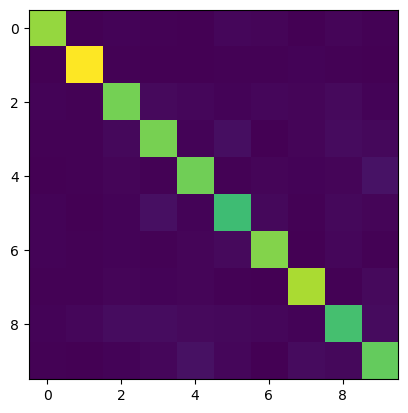

In [71]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
plt.imshow(matrix)
print(f'The total accuracy: {np.trace(matrix)/ matrix.sum():.4f}')
print(f'DecisionTreeClassifier Score on TRAIN set: {dtc.score(X_train, y_train):.4}')
print(f'DecisionTreeClassifier Score on TEST set: {dtc.score(X_test, y_test):.4}')
fi = dtc.feature_importances_

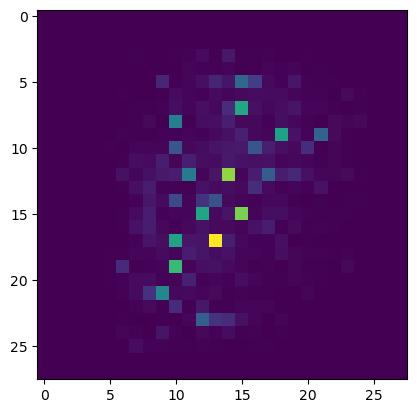

In [72]:

plt.imshow(fi.reshape(28,28))

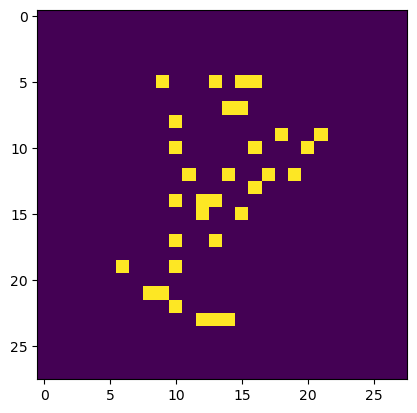

In [75]:
plt.imshow(np.where(fi>0.005,1,0).reshape(28,28))

In [86]:
dtc.predict_proba(X_test).sum(axis=1).max()

1.0

(32,)


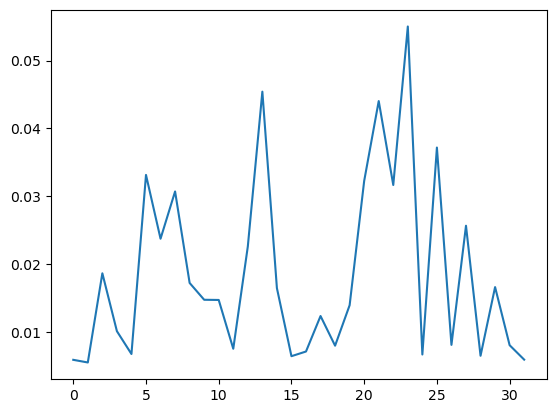

In [35]:
# Cheking for different values of feature importance how many features are there
a = 0.005
plt.plot(fi[fi>a])
print(fi[fi>a].shape)

In [52]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_features':(3,8,11, 20,32), 'max_depth': range(5,50)}

model = DecisionTreeClassifier()
grid_GBC = GridSearchCV(model, parameters)
grid_GBC.fit(X_train, y_train)

best_params = grid_GBC.best_params_

print(" Results from Grid Search " )
print(f'The best estimator across ALL searched params on TRAIN set: {grid_GBC.best_estimator_}')
print(f'The best score across ALL searched params on TRAIN set: {grid_GBC.best_score_:.4f}')
print(f'The best parameters across ALL searched params on TRAIN set: {best_params}')

 Results from Grid Search 
The best estimator across ALL searched params on TRAIN set: DecisionTreeClassifier(max_depth=16, max_features=32)
The best score across ALL searched params on TRAIN set: 0.8322
The best parameters across ALL searched params on TRAIN set: {'max_depth': 16, 'max_features': 32}


The total accuracy: 0.8402
DecisionTreeClassifier Score on TRAIN set: 0.9758
DecisionTreeClassifier Score on TEST set: 0.8402


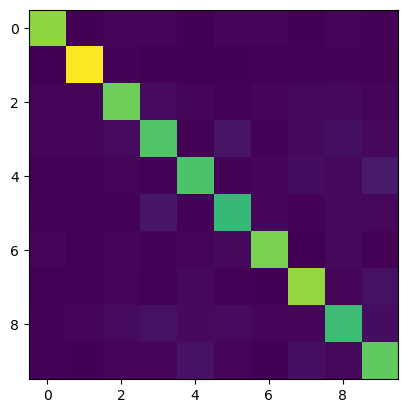

In [87]:
dtc = DecisionTreeClassifier(max_features=32, max_depth=16)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
plt.imshow(matrix)
print(f'The total accuracy: {np.trace(matrix)/ matrix.sum():.4f}')
print(f'DecisionTreeClassifier Score on TRAIN set: {dtc.score(X_train, y_train):.4}')
print(f'DecisionTreeClassifier Score on TEST set: {dtc.score(X_test, y_test):.4}')
fi = dtc.feature_importances_

In [89]:
np.unique(dtc.predict_proba(X_test))

array([0.00000000e+00, 2.46184146e-04, 3.89863548e-04, 4.27533134e-04,
       7.03729768e-04, 7.79727096e-04, 8.55066268e-04, 8.82612533e-04,
       1.05708245e-03, 1.07181136e-03, 1.15340254e-03, 1.16959064e-03,
       1.23092073e-03, 1.29701686e-03, 1.31233596e-03, 1.40745954e-03,
       1.43266476e-03, 1.51515152e-03, 1.71013254e-03, 1.76522507e-03,
       1.96947317e-03, 2.02839757e-03, 2.11416490e-03, 2.14362272e-03,
       2.21565731e-03, 2.45098039e-03, 2.64783760e-03, 2.74725275e-03,
       2.86532951e-03, 3.41880342e-03, 3.46020761e-03, 3.51864884e-03,
       3.64963504e-03, 3.89105058e-03, 4.05679513e-03, 4.28724544e-03,
       4.29799427e-03, 4.31034483e-03, 4.42477876e-03, 4.52488688e-03,
       4.90196078e-03, 4.92004920e-03, 5.31914894e-03, 5.61797753e-03,
       5.84795322e-03, 6.15006150e-03, 6.17283951e-03, 6.56167979e-03,
       6.62251656e-03, 6.89655172e-03, 6.94444444e-03, 7.04225352e-03,
       7.14285714e-03, 7.29927007e-03, 7.35294118e-03, 7.38007380e-03,
      

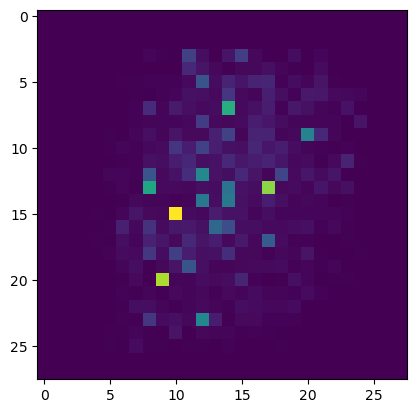

In [70]:
plt.imshow(fi.reshape(28,28))

In [54]:
# Let's binarize the data and train a new tree:

model_param = 150
X_train_bool = np.where(X_train>model_param,1,0)
X_test_bool = np.where(X_test>model_param,1,0)

The total accuracy: 0.8548
DecisionTreeClassifier Score on TRAIN set: 1.0
DecisionTreeClassifier Score on TEST set: 0.8548


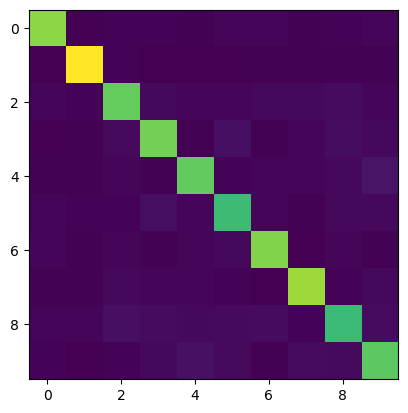

In [61]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train_bool, y_train)
y_pred = dtc.predict(X_test_bool)
matrix = confusion_matrix(y_test, y_pred)
plt.imshow(matrix)
print(f'The total accuracy: {np.trace(matrix)/ matrix.sum():.4f}')
print(f'DecisionTreeClassifier Score on TRAIN set: {dtc.score(X_train_bool, y_train):.4}')
print(f'DecisionTreeClassifier Score on TEST set: {dtc.score(X_test_bool, y_test):.4}')
fi = dtc.feature_importances_

(9,)


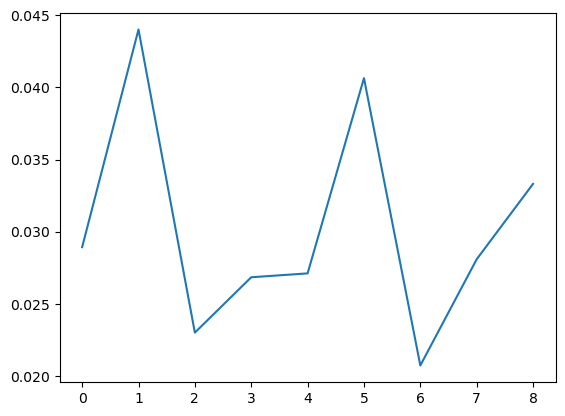

In [59]:
# Cheking for different values of feature importance how many features are there
a = 0.02
plt.plot(fi[fi>a])
print(fi[fi>a].shape)

In [64]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_features':range(5,35,3), 'max_depth': range(5,50,3)}

model = DecisionTreeClassifier()
grid_GBC = GridSearchCV(model, parameters)
grid_GBC.fit(X_train_bool, y_train)

best_params = grid_GBC.best_params_

print(" Results from Grid Search " )
print(f'The best estimator across ALL searched params on TRAIN set: {grid_GBC.best_estimator_}')
print(f'The best score across ALL searched params on TRAIN set: {grid_GBC.best_score_:.4f}')
print(f'The best parameters across ALL searched params on TRAIN set: {best_params}')

 Results from Grid Search 
The best estimator across ALL searched params on TRAIN set: DecisionTreeClassifier(max_depth=38, max_features=32)
The best score across ALL searched params on TRAIN set: 0.7993
The best parameters across ALL searched params on TRAIN set: {'max_depth': 38, 'max_features': 32}


The total accuracy: 0.8004
DecisionTreeClassifier Score on TRAIN set: 1.0
DecisionTreeClassifier Score on TEST set: 0.8004


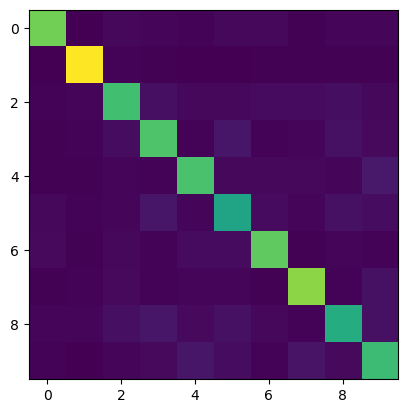

In [65]:
dtc = DecisionTreeClassifier(max_features=32, max_depth=38)
dtc.fit(X_train_bool, y_train)
y_pred = dtc.predict(X_test_bool)
matrix = confusion_matrix(y_test, y_pred)
plt.imshow(matrix)
print(f'The total accuracy: {np.trace(matrix)/ matrix.sum():.4f}')
print(f'DecisionTreeClassifier Score on TRAIN set: {dtc.score(X_train_bool, y_train):.4}')
print(f'DecisionTreeClassifier Score on TEST set: {dtc.score(X_test_bool, y_test):.4}')